In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import fsspec
import cftime
from dask import optimize
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression

/var/folders/7y/lr_w90f56s35gmw3l6ghkz_w0000gn/T/ipykernel_20898/3290393657.py:6: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

In [3]:
df_area = df.query("variable_id == 'areacella' & source_id == 'CESM2' & experiment_id =='historical'")
ds_area = xr.open_zarr(fsspec.get_mapper(df_area.zstore.values[-1]), consolidated=True)
total_area = ds_area.areacella.sum(dim=['lon', 'lat'])

In [4]:
# df_ta_ncar = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2' & variable_id == 'tas'  & institution_id == 'NCAR'")
df_prw_ncar_his = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2'  & variable_id == 'prw' & institution_id == 'NCAR' & experiment_id == 'historical'")

# get the path to a specific zarr store (the first one from the dataframe above)
zstore_his = df_prw_ncar_his.zstore.values[-1]
print(zstore_his)

# create a mutable-mapping-style interface to the store
mapper_his = fsspec.get_mapper(zstore_his)

# open it using xarray and zarr
ds_prw_his = xr.open_zarr(mapper_his, consolidated=True)
display(ds_prw_his)


# date_threshold = cftime.DatetimeNoLeap(1550, 1, 1)
# ds_tas_his_plt = ds_tas_his.where(ds_tas_his.time > date_threshold, drop=True)
# # weighted product
# tas_timeseries_his = (ds_tas_his_plt.tas * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
# # convert to np array
# array_tas_ts = np.array(tas_timeseries_his)
# # plt.plot(array_tas_ts)
# # plt.show()
# year_tas_ts = np.mean(array_tas_ts.reshape(1980//12, 12), axis=1)
# # plt.plot(year_tas_ts)
# # plt.show()

gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r11i1p1f1/Amon/prw/gn/v20190514/


<xarray.Dataset>
Dimensions:    (lat: 192, nbnd: 2, lon: 288, time: 1980)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    prw        (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    variable_id:            prw
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/8e2bf5bf-2173-4813-92b0-c53c5589979c...
    version_id:             v20190514

## The coordinate of arctic circle, Russia, and Canada are defined here

In [5]:
lats = np.array(ds_prw_his.lat)

n = len(lats)
arctic_lat = lats[-26]
arctic_lat

66.43979057591622

In [6]:
rus_coor = [lats[-24], 103.75]
can_coor = [lats[-24], 240]
print(rus_coor, can_coor)

[68.32460732984293, 103.75] [68.32460732984293, 240]


In [7]:
# ds_prw_his.prw.sel(time='1950-07', lat=equator_lat).squeeze().plot()
# ds_prw_his.prw.sel(lat = equator_lat, time='1950-07').squeeze().plot()

In [8]:
(ds_prw_his.prw * ds_area.areacella).sel(lat = arctic_lat)

<xarray.DataArray (time: 1980, lon: 288)>
dask.array<getitem, shape=(1980, 288), dtype=float32, chunksize=(600, 288), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 66.44
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00

## The timeseries of Water Vapor Path for arctic circle, Russia, and Canada are defined here

In [9]:
arc_area = ds_area.areacella.sel(lat = arctic_lat).sum(dim=['lon'])

arc_prw_ts = (ds_prw_his.prw * ds_area.areacella).sel(lat=arctic_lat).sum(dim=['lon']) / arc_area
# convert to np array
array_arc_prw_ts = np.array(arc_prw_ts)

time = np.arange(1850, 2015, 1/12)

In [10]:
array_rus_prw_ts = np.array(ds_prw_his.prw.sel(lat=rus_coor[0], lon=rus_coor[1]))
array_can_prw_ts = np.array(ds_prw_his.prw.sel(lat=can_coor[0], lon=can_coor[1]))

In [11]:
len(array_rus_prw_ts)

1980

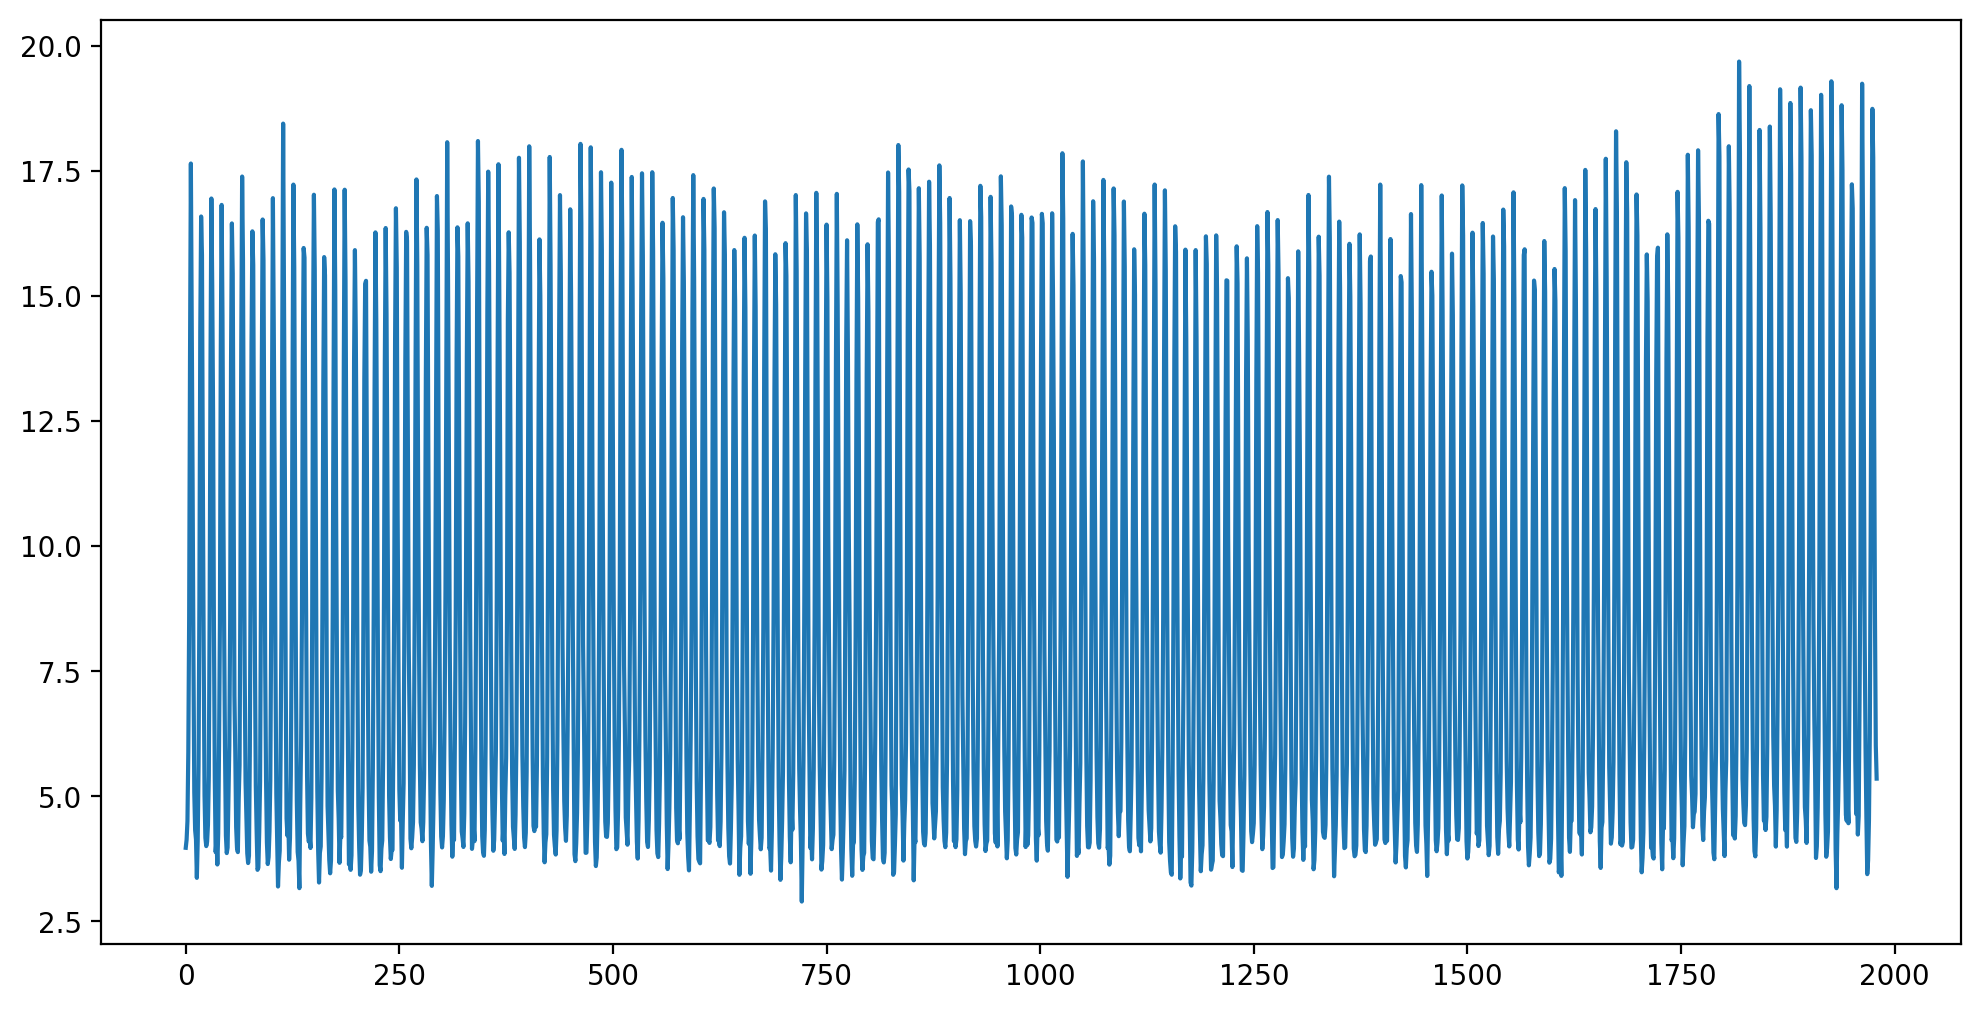

In [12]:
year_prw_ts = np.mean(array_arc_prw_ts.reshape(1980//12, 12), axis=1)
plt.plot(array_arc_prw_ts)
plt.show()

## The timeseries of Surface Temperature for Arctic Area, Russia, and Canada are defined here

In [13]:
df_tas_ncar_his = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2'  & variable_id == 'tas' & institution_id == 'NCAR' & experiment_id == 'historical'")
zstore_his = df_tas_ncar_his.zstore.values[-1]
print(zstore_his)
mapper_his = fsspec.get_mapper(zstore_his)
ds_tas_his = xr.open_zarr(mapper_his, consolidated=True)
# date_threshold = cftime.DatetimeNoLeap(1550, 1, 1)
# ds_tas_his_plt = ds_tas_his.where(ds_tas_his.time > date_threshold, drop=True)
arc_tas_ts = (ds_tas_his.tas * ds_area.areacella).sel(lat=arctic_lat).sum(dim=['lon']) / arc_area

array_arc_tas_ts = np.array(arc_tas_ts)
array_rus_tas_ts = np.array(ds_tas_his.tas.sel(lat=rus_coor[0], lon=rus_coor[1]))
array_can_tas_ts = np.array(ds_tas_his.tas.sel(lat=can_coor[0], lon=can_coor[1]))

gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r11i1p1f1/Amon/tas/gn/v20190514/


### Want to estimate $TPW \propto \exp(\alpha + \beta * \Delta T)$. This is the simplified Calusius-Claperon formula in Marshall & Plumb

## The alpha and beta in the output are in this formula: $TPW = \exp(\alpha) \cdot \exp(\beta T)$

## Linear Regression for Arctic Region

{'fit_intercept': True, 'normalize': 'deprecated', 'copy_X': True, 'n_jobs': None, 'positive': False, 'n_features_in_': 1, 'coef_': array([0.04879927], dtype=float32), 'rank_': 1, 'singular_': array([479.3822], dtype=float32), 'intercept_': -10.988858}
alpha: 1.6888827303773724e-05
beta: 0.048799268901348114


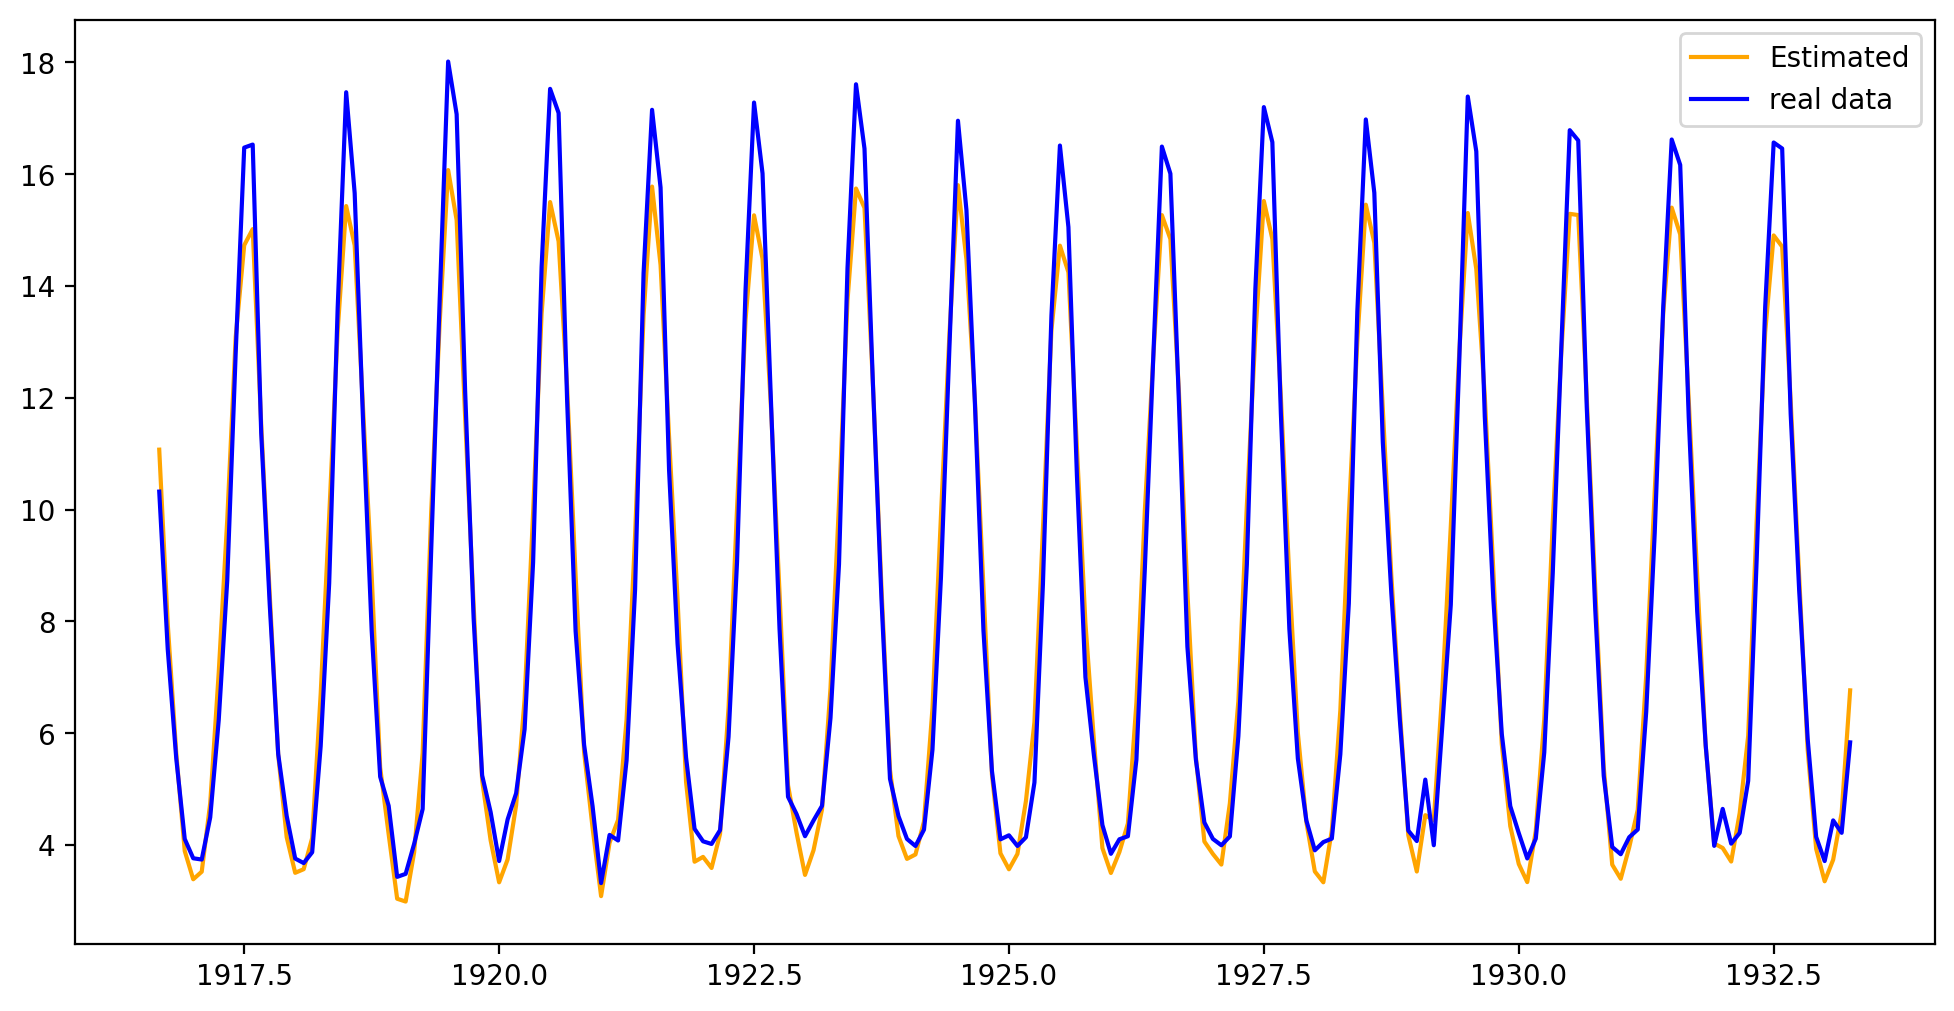

In [14]:
ln_TPW = np.log(array_arc_prw_ts)
X_tas_ts = array_arc_tas_ts.reshape(-1, 1)

LR_model = LinearRegression()
LR_model.fit(X_tas_ts, ln_TPW)

print(vars(LR_model))

beta = LR_model.coef_[0]  # Slope is negative feedback parameter
alpha = LR_model.intercept_  # Intercept is radiative forcing

print(f"alpha: {np.exp(alpha)}")
print(f"beta: {beta}")

i_left, i_right = 800, 1000
estimated_TPW_ts = np.exp(alpha + beta * array_arc_tas_ts)
plt.plot(time[i_left : i_right], estimated_TPW_ts[i_left : i_right], label="Estimated", color="orange")
plt.plot(time[i_left : i_right], array_arc_prw_ts[i_left : i_right], label="real data", color="blue")
plt.legend()
plt.show()

In [15]:
ln_TPW = np.log(array_rus_prw_ts)
X_tas_ts = array_rus_tas_ts.reshape(-1, 1)

LR_model = LinearRegression()
LR_model.fit(X_tas_ts, ln_TPW)

print(vars(LR_model))

beta_rus = LR_model.coef_[0]  # Slope is negative feedback parameter
alpha_rus = LR_model.intercept_  # Intercept is radiative forcing

print(f"e^alpha: {np.exp(alpha_rus)}")
print(f"beta: {beta_rus}")
# i_left, i_right = 800, 1000
# estimated_TPW_ts = np.exp(alpha + beta * array_sgp_tas_ts)
# plt.plot(estimated_TPW_ts, label="Estimated", color="orange")
# plt.plot(array_sgp_prw_ts, label="real data", color="blue")
# plt.legend()
# plt.show()

{'fit_intercept': True, 'normalize': 'deprecated', 'copy_X': True, 'n_jobs': None, 'positive': False, 'n_features_in_': 1, 'coef_': array([0.04914232], dtype=float32), 'rank_': 1, 'singular_': array([673.7854], dtype=float32), 'intercept_': -11.16507}
e^alpha: 1.4160281352815218e-05
beta: 0.049142319709062576


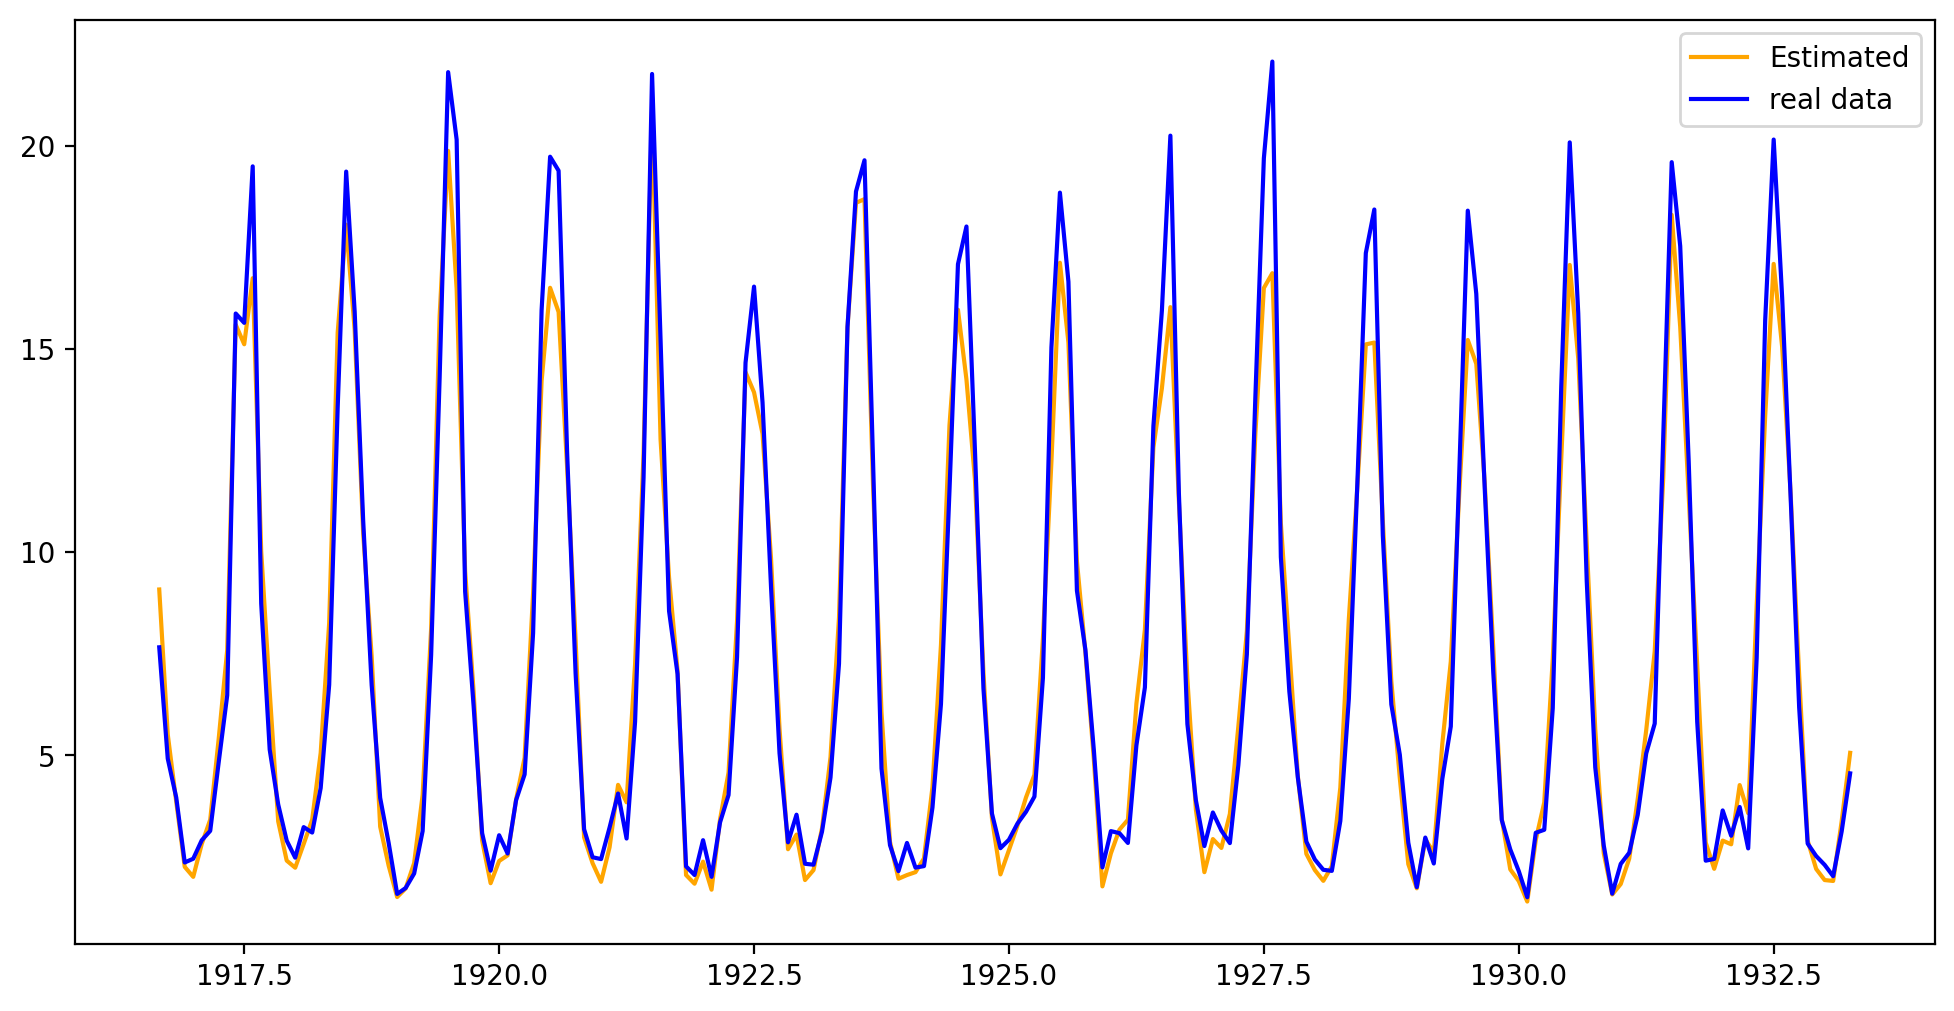

In [16]:
i_left, i_right = 800, 1000
estimated_TPW_ts_rus = np.exp(alpha_rus + beta_rus * array_rus_tas_ts)
plt.plot(time[i_left : i_right], estimated_TPW_ts_rus[i_left : i_right], label="Estimated", color="orange")
plt.plot(time[i_left : i_right], array_rus_prw_ts[i_left : i_right], label="real data", color="blue")
plt.legend()
plt.show()

In [17]:
ln_TPW = np.log(array_can_prw_ts)
X_tas_ts = array_can_tas_ts.reshape(-1, 1)

LR_model = LinearRegression()
LR_model.fit(X_tas_ts, ln_TPW)

print(vars(LR_model))

beta_can = LR_model.coef_[0]  # Slope is negative feedback parameter
alpha_can = LR_model.intercept_  # Intercept is radiative forcing

print(f"e^ alpha: {np.exp(alpha_can)}")
print(f"beta: {beta_can}")

estimated_TPW_ts_can = np.exp(alpha_can + beta_can * array_can_tas_ts)


{'fit_intercept': True, 'normalize': 'deprecated', 'copy_X': True, 'n_jobs': None, 'positive': False, 'n_features_in_': 1, 'coef_': array([0.04917241], dtype=float32), 'rank_': 1, 'singular_': array([571.8232], dtype=float32), 'intercept_': -11.101124}
e^ alpha: 1.50953501361073e-05
beta: 0.049172405153512955


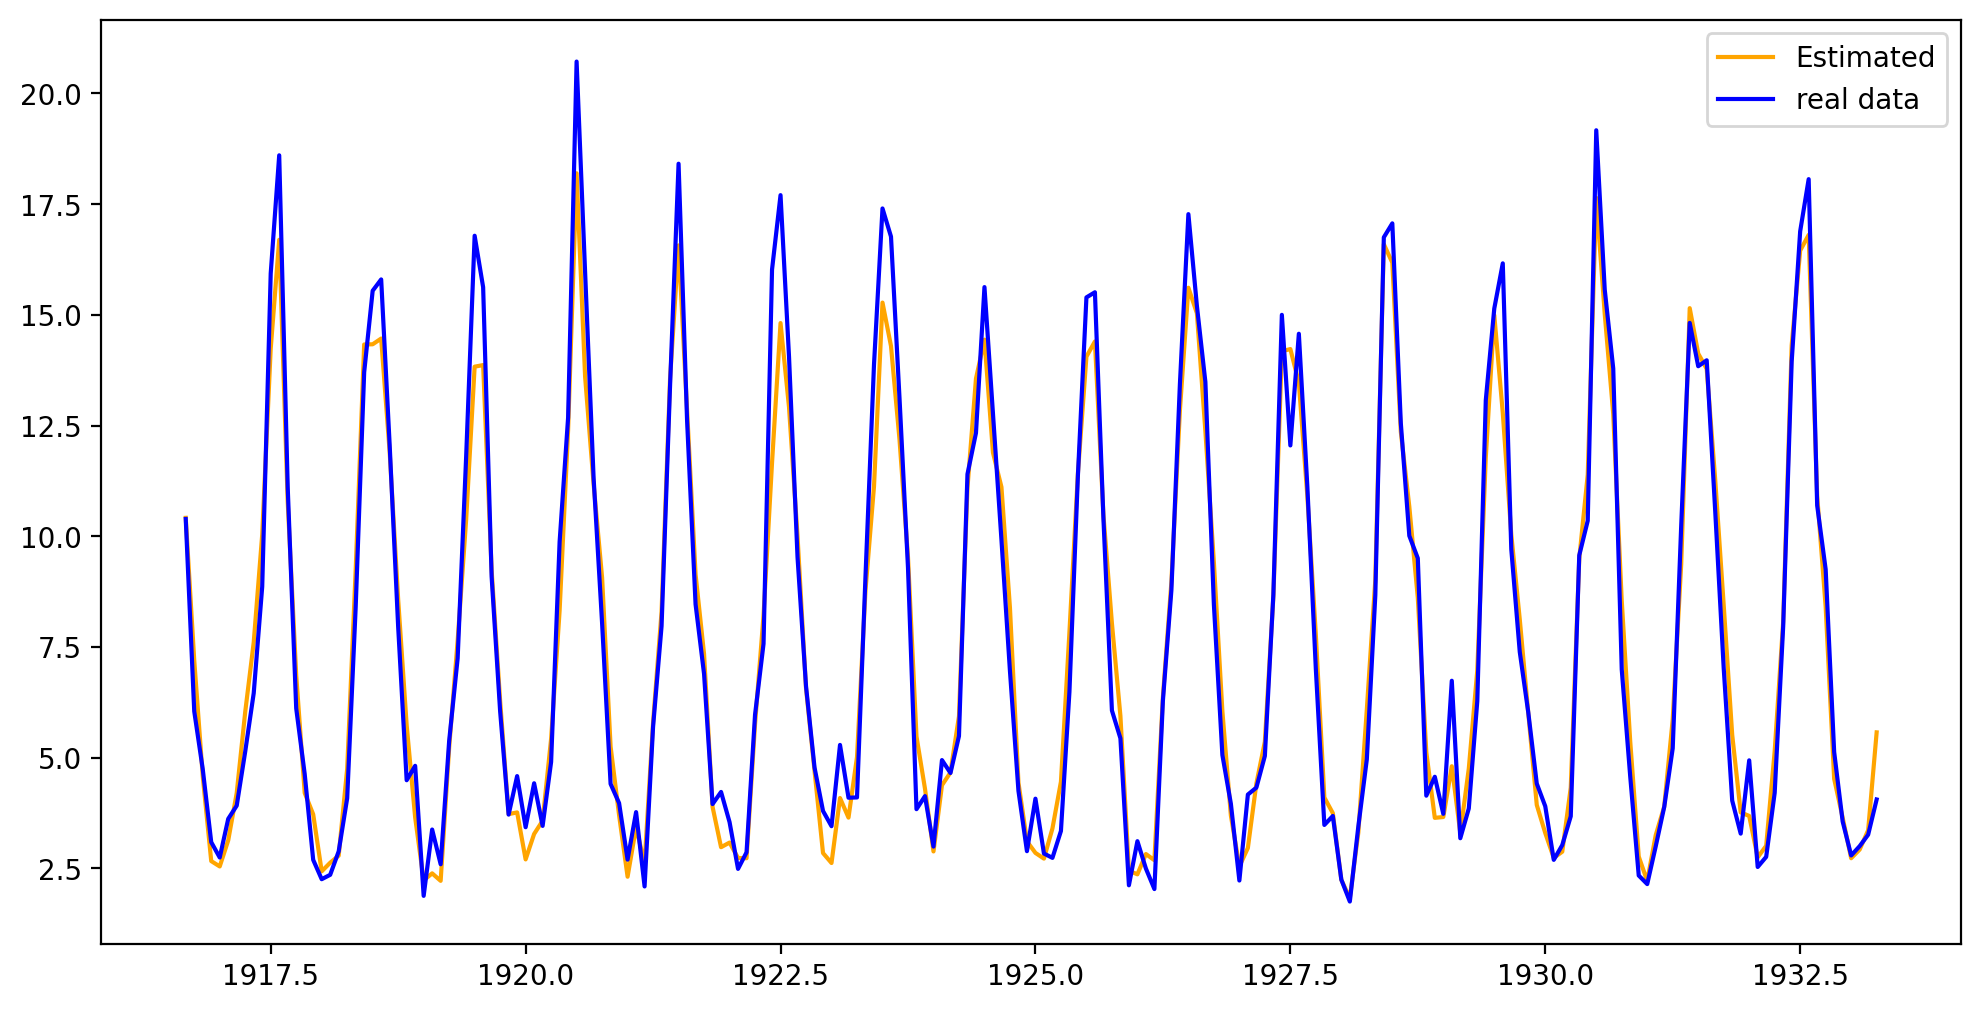

In [18]:

# The interval, from 0 to 1980
i_left, i_right = 800, 1000
plt.plot(time[i_left : i_right], estimated_TPW_ts_can[i_left : i_right], label="Estimated", color="orange")
plt.plot(time[i_left : i_right], array_can_prw_ts[i_left : i_right], label="real data", color="blue")
plt.legend()
plt.show()